# Exercises 13-1 Survival Analysis
author: Rachel Nelson

date: 11/14/2020

class: DSC530-T303 Data Exploration and Analysis (2211-1)

**Exercise:**    In NSFG Cycles 6 and 7, the variable `cmdivorcx` contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.


In [61]:
# Import Packages
import pandas as pd
import numpy as np
import thinkplot
import thinkstats2
import survival
import nsfg

In [62]:
# cycles 6 and 7
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

In [63]:
def CleanData(resp):
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)
    resp['notdivorced'] = resp.cmdivorcx.isnull().astype(int)
    resp['duration'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp['durationsofar'] = (resp.cmintvw - resp.cmmarrhx) / 12.0
    month0 = pd.to_datetime('1899-12-15')
    dates = [month0 + pd.DateOffset(months=cm)
             for cm in resp.cmbirth]
    resp['decade'] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [64]:
# Clean the dataset using CleanData
CleanData(resp6)
CleanData(resp7)

#Make dataframes for those who ever married
married6 = resp6[resp6.evrmarry==1]
married7 = resp7[resp7.evrmarry==1]

In [65]:
def ResampleDivorceCurve(resps):
    for _ in range(11):
        samples = [thinkstats2.ResampleRowsWeighted(resp)
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color='#225EA8', alpha=0.1)
    thinkplot.Show(xlabel='years')

In [70]:
# Plots divorce curves
def ResampleDivorceCurveByDecade(resps):
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp)
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)
        EstimateSurvivalByDecade(groups, alpha=0.1)
    thinkplot.Config(xlabel='Years',
                     ylabel='undivorced fraction',
                     title='Divorce Curve by Decade')

In [67]:
# Groups respondents by decade and plots survival curves
def EstimateSurvivalByDecade(groups, **options):
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)

In [68]:
# Estimates survival curve
def EstimateSurvival(resp):
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()
# Hazard Function
    hf = survival.EstimateHazardFunction(complete, ongoing)\
# Survival Function
    sf = hf.MakeSurvival()
    return hf, sf

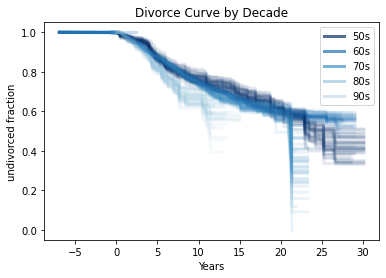

In [71]:
ResampleDivorceCurveByDecade([married6, married7])
